# How does Othello-GPT edit its world model?

In [1]:
# imports
import transformer_lens as lens
from transformer_lens import HookedTransformer, HookedTransformerConfig
import autocircuit
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import einops
from fancy_einsum import einsum

c:\Users\aidan\Documents\Programming\autocircuit\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# get model from hf
model = HookedTransformer.from_pretrained("othello-gpt")

ConnectionError: HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/Baidicoot/Othello-GPT-Transformer-Lens/tree/main?recursive=True (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001A397663B50>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# get Neel Nanda's linear probes and convert them to the HookedTransformer format
# going to focus on layer 6 because apparently that one works pretty good
probe = torch.load("main_linear_probe.pth", map_location=device)

In [ ]:
# indexing
itos = [-100] + list(range(0,27)) + list(range(30,35)) + list(range(37,64))
stoi = {s:i for i,s in enumerate(itos)}


rows = list("abcdefgh")
columns = [str(_) for _ in range(1, 9)]

def permit(s):
    s = s.lower()
    if len(s) != 2:
        return -1
    if s[0] not in rows or s[1] not in columns:
        return -1
    return rows.index(s[0]) * 8 + columns.index(s[1])

import textwrap

In [ ]:
# test linear probe
moves = textwrap.wrap("C4c3D3", 2)
tokens = torch.tensor([stoi[permit(move)] for move in moves]).unsqueeze(0).to(device)

# get activations
_, cache = model.run_with_cache(tokens)

# get activations for layer 6
activations = cache["resid_post", 6]

# get board state predictions
probe_out = einsum(
    "batch pos d_model, modes d_model rows cols options -> modes batch pos rows cols options",
    activations,
    probe,
)

probe_log_probs = probe_out.log_softmax(-1)

print(probe_log_probs.shape)

board_state = np.zeros((8, 8))

for i in range(8):
    for j in range(8):
        board_state[i, j] = np.exp(probe_log_probs[2, -1, -1, i, j, 0].item())

torch.Size([3, 1, 3, 8, 8, 3])


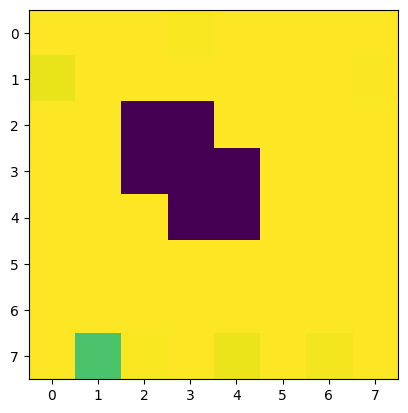

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(board_state)
plt.show()

In [ ]:
print(cache.keys())

dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_pre', 'block

In [ ]:
print(model.hook_dict.keys())

dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_z', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_result', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_q_input', 'blocks.0.hook_k_input', 'blocks.0.hook_v_input', 'blocks.0.hook_attn_out', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_pre', 'blocks.0.hook_resid_mid', 'blocks.0.hook_resid_post', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_z', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_result', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_q_input', 'blocks.

In [ ]:
nodes = []
edges = []

nodes.append((f"blocks.0.hook_resid_pre", model.hook_dict[f"blocks.0.hook_resid_pre"]))

for l in range(8):
    input_resid = f"blocks.{l-1}.hook_resid_post" if l != 0 else "blocks.0.hook_resid_pre"
    edges.append((f"blocks.{l}.hook_resid_mid", input_resid))
    edges.append((f"blocks.{l}.hook_resid_post", f"blocks.{l}.hook_resid_mid"))
    mid_hook = autocircuit.PartialHook(f"blocks.{l}.hook_resid_mid", lambda x: x, lambda x, y: y)
    nodes.append((f"blocks.{l}.hook_resid_mid", mid_hook))
    post_hook = autocircuit.PartialHook(f"blocks.{l}.hook_resid_post", lambda x: x, lambda x, y: y)
    nodes.append((f"blocks.{l}.hook_resid_post", post_hook))

graph = autocircuit.ComputeGraph(dict(nodes), edges, "blocks.7.hook_resid_post")

In [ ]:
cf_moves = "C4c3E6"
cf_tokens = torch.tensor([stoi[permit(move)] for move in textwrap.wrap(cf_moves, 2)]).unsqueeze(0).to(device)
_, cf_cache = model.run_with_cache(cf_tokens)

def diff(x, y):
    print(x, y)
    return F.mse_loss(x, y)

In [ ]:
print(graph.get_parents("blocks.7.hook_resid_post"))
print(graph.nodes["blocks.7.hook_resid_mid"].hook_point)
print(graph.nodes["blocks.7.hook_resid_mid"].hook_read(cf_cache["blocks.7.hook_resid_mid"]))

['blocks.7.hook_resid_mid']
blocks.7.hook_resid_mid
tensor([[[-1.5627, -1.0174, -1.8714,  ..., -0.0351, -1.6321, -2.0861],
         [-0.1978,  0.1564,  0.4435,  ...,  1.1592,  1.8622, -0.2284],
         [-1.4027,  0.0038,  0.1416,  ..., -0.2897,  0.9953,  0.6395]]])


In [3]:
out = autocircuit.path_tracing(model, graph, "blocks.7.hook_resid_post", tokens, cf_cache, diff, 0, "zero")

NameError: name 'model' is not defined